In [ ]:
from IPython.display import HTML
HTML('''<h2>IMT 575: Build DGA model using XGBOOST in Sagemaker</h2>
<b><pre>
    Authors: 
    Aftab Alam
    </pre>
</b> 
<p>Date/Time: <span id="datetime"></span></p><script>var dt = new Date();
document.getElementById("datetime").innerHTML=dt.toLocaleString();</script> </p>''')

In [14]:
# In order to run aws boto3 apis locally, please setup proper role(sagement, lambda execution, cloudwatch ..)
# below code will read credential and that can be passed in boto3 session.
# Thanks to https://gist.github.com/wjimenez5271/defeede8eb4a63afc9d8
def get_profile_credentials(profile_name):
    from configparser import ConfigParser
    from configparser import ParsingError
    from configparser import NoOptionError
    from configparser import NoSectionError
    from os import path
    config = ConfigParser()
    config.read([path.join(path.expanduser("~"),'.aws/credentials')])
    try:
        aws_access_key_id = config.get(profile_name, 'aws_access_key_id')
        aws_secret_access_key = config.get(profile_name, 'aws_secret_access_key')
    except ParsingError:
        print('Error parsing config file')
        raise
    except (NoSectionError, NoOptionError):
        try:
            aws_access_key_id = config.get('default', 'aws_access_key_id')
            aws_secret_access_key = config.get('default', 'aws_secret_access_key')
        except (NoSectionError, NoOptionError):
            print('Unable to find valid AWS credentials')
            raise
    return aws_access_key_id, aws_secret_access_key
aws_access_key_id,aws_secret_access_key = get_profile_credentials('aftabuw')
LOCAL=1

In [6]:
import sys
! conda install -y -c conda-forge ipywidgets
! pip install tldextract


Solving environment: ...working... done

# All requested packages already installed.



jupyter-console 5.2.0 has requirement prompt_toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.2 which is incompatible.
awscli 1.15.85 has requirement botocore==1.10.84, but you'll have botocore 1.16.4 which is incompatible.
awscli 1.15.85 has requirement PyYAML<=3.13,>=3.10, but you'll have pyyaml 5.3.1 which is incompatible.
awscli 1.15.85 has requirement s3transfer<0.2.0,>=0.1.12, but you'll have s3transfer 0.3.3 which is incompatible.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [11]:
import time
import sys
import os
import boto3
import numpy as np
import pandas as pd
# for extracting domain name
import tldextract

%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt

# Sagemake 
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.predictor import csv_serializer

# sklearn
from sklearn.model_selection import train_test_split

# enable flag to how all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [43]:
# Setting up bot3 sessions and client
print(f"Runing locally : {LOCAL==1}")
if(LOCAL==1):
    role='arn:aws:iam::099176660580:role/service-role/AmazonSageMaker-ExecutionRole-20200505T194950'
    boto_session = boto3.Session(aws_access_key_id=aws_access_key_id,
                      aws_secret_access_key=aws_secret_access_key)
    region=boto_session.region_name
    sagemaker_client = boto3.client('sagemaker',aws_access_key_id=aws_access_key_id,
                                    aws_secret_access_key=aws_secret_access_key,
                                    region_name=region
                                   )
    sagemaker_runtime_client = boto3.client('sagemaker-runtime',aws_access_key_id=aws_access_key_id,
                                    aws_secret_access_key=aws_secret_access_key,
                                    region_name=region
                                   )
    sagemaker_session = sagemaker.Session(boto_session=boto_session, 
                               sagemaker_client=sagemaker_client, 
                               sagemaker_runtime_client=sagemaker_runtime_client,)
    bucket = sagemaker_session.default_bucket()
    # change this ARN for role that u need to use for sage maker
else:
    # if running it from sagemake notebook instance
    role = sagemaker.get_execution_role()
    boto_session = boto3.Session()
    region=boto_session.region_name
    sagemaker_client = boto3.client('sagemaker',
                                    region_name=region
                                   )
    sagemaker_runtime_client = boto3.client('sagemaker-runtime',
                                    region_name=region
                                   )
    region = boto3.Session().region_name

    # S3 bucket for saving code and model artifacts.
    # Feel free to specify a different bucket and prefix
    sagemaker_session = sagemaker.Session()
    bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/xgboost'
# customize to your bucket where you have stored the data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region, bucket)

Runing locally : True


# Data Clean up and Feature engineering

**Function for spliting data and savind it in s3 as well local file system**

In [21]:
%%time
# split data and save in s3

import io
import boto3
import random
from sklearn.model_selection import train_test_split

def appendXY(X,Y):
    df = pd.DataFrame(Y)
    print(df.shape)
    df.columns = ['Y']
    dfx = pd.DataFrame(X)
    print(dfx.shape)
    return pd.concat([df,dfx],axis=1)
   

def data_split(features,output_label,train_file, validation_file, test_file,test_size=0.2, random_state=42):

    X_train, X_test, y_train, y_test = train_test_split(features, output_label, test_size=test_size, random_state=random_state)
    test_df = appendXY(X_test,y_test)
    test_df.to_csv(test_file,header=False,index=False)
    
    X_train, X_test, y_train, y_test = train_test_split( X_train, y_train, test_size=test_size, random_state=random_state)
    train_df = appendXY(X_train,y_train)
    train_df.to_csv(train_file,header=False,index=False)
    
    valid_df = appendXY(X_test,y_test)
    valid_df.to_csv(validation_file,header=False,index=False)


def write_to_s3(fobj, bucket, key):  
    return boto_session.resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(bucket, channel, filename):
    fobj=open(filename, 'rb')
    key = prefix+'/'+channel
    url = 's3://{}/{}/{}'.format(bucket, key, filename)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)

Wall time: 1.15 s


**Download DGA and benign data set from S3 bucket**

In [22]:
# download file from S3
FILE_DATA = 'domainsDataSet'
s3 = boto_session.client('s3')
s3.download_file(bucket, 'newDataSample.csv', FILE_DATA)

Load and inspect data

In [23]:
# Load the dataset
df_domains = pd.read_csv(FILE_DATA)

df_domains.tail()
df_domains.head()
df_domains.groupby('domain_type').agg('count')

,domain,domain_type
999995,kapital-rus.ru,benign
999996,kaufroboter.de,benign
999997,naikmotor.com,benign
999998,altengroup.sharepoint.com,benign
999999,icampusj.net,benign


,domain,domain_type
0,giamanek.com,benign
1,kennycason.com,benign
2,uniconbg.com,benign
3,ctnnbbrcuhusvjcdbypk.mx,dga
4,zhztea.com,benign


,domain
domain_type,
benign,499999
dga,500000


Function to extract domain from full domain name

In [25]:
%%time

def extract_domain_subdomain(record):
    domain = record.domain
    ret=''
    try:
        ext = tldextract.extract(domain)
        ret = ext.domain
    except :
        print(record)
    return ret
def get_y(row):
    if row.domain_type.lower()=='dga':
        return 1
    elif row.domain_type.lower()=='benign':
        return 0
    else :
        return 1
    


domain            NaN
domain_type    benign
Name: 765103, dtype: object
Wall time: 52.1 s


### Create new columns for domain and dga binary

In [ ]:
df_domains.loc[:,'domain_subdomain'] = df_domains.apply(lambda row : extract_domain_subdomain(row), axis=1 )
## 1 for dga and 0 for benign
df_domains.loc[:,'Y'] = df_domains.apply(lambda row : get_y(row), axis=1 )

### function to convert domain into features

In [26]:
VALID_CHARS = 'abcdefghijklmnopqrstuvwxyz0123456789-_.'
LOOKUP_TABLE = None
def pad(l, content, width):
        l.extend([content] * (width - len(l)))
        return l

def features_extract(domain): 
    
    global VALID_CHARS    
    global LOOKUP_TABLE    
    if not LOOKUP_TABLE:        
        LOOKUP_TABLE = dict()       
        idx = 1
        for c in VALID_CHARS:
            LOOKUP_TABLE[c] = int(idx)            
            idx += int(1)    
    #ds = tldextract.extract(fqdn)    
    #domain = ds.domain 
       
    rvalue = list()  
    if len(domain)<=63 and ' ' not in domain:
        for c in domain.lower():        
            rvalue.append(LOOKUP_TABLE[c])
    else: 
        #print(domain)
        pass
            
    rvalue=pad(rvalue,0,63)    
    return rvalue


In [28]:
## tldextract example 
## test functions 
url = 'https://www.abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcde.abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijk.abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijk.abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijk.com'
ext=tldextract.extract(url)
ext
print(features_extract(ext.domain))


ExtractResult(subdomain='www.abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcde.abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijk.abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijk', domain='abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijk', suffix='com')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


### Create feature Vector for all records

In [29]:
# features X vector
X = [features_extract(D) for D in df_domains.domain_subdomain]
X = np.array(X)
X.shape


(1000000, 63)

Split data feature set and create files that can be used for sagemaker model

In [30]:
%%time
# split df in training , validation and test and save as file
FILE_TRAIN = 'domainsDataSet.train'
FILE_VALIDATION = 'domainsDataSet.validation'
FILE_TEST = 'domainsDataSet.test'

data_split(features=X,output_label=df_domains['Y'].values,train_file=FILE_TRAIN
           ,validation_file=FILE_VALIDATION, test_file=FILE_TEST,test_size=0.2, random_state=42)

#upload the files to the S3 bucket
upload_to_s3(bucket, 'train', FILE_TRAIN)
upload_to_s3(bucket, 'validation', FILE_VALIDATION)
upload_to_s3(bucket, 'test', FILE_TEST)


(200000, 1)
(200000, 63)
(640000, 1)
(640000, 63)
(160000, 1)
(160000, 63)
Writing to s3://sagemaker-us-west-2-099176660580/sagemaker/xgboost/train/domainsDataSet.train
Writing to s3://sagemaker-us-west-2-099176660580/sagemaker/xgboost/validation/domainsDataSet.validation
Writing to s3://sagemaker-us-west-2-099176660580/sagemaker/xgboost/test/domainsDataSet.test
Wall time: 4min 3s


In [39]:
# check fields()
from sys import platform
print("Running for platforr: ",platform)
if 'win' in platform:
    print("Validation data")
    !powershell -command "& {Get-Content domainsDataSet.validation -TotalCount 2}"
    print("test data")
    !powershell -command "& {Get-Content domainsDataSet.test -TotalCount 2}"
    print("train data")
    !powershell -command "& {Get-Content 'domainsDataSet.train' -TotalCount 2}"
else:
    print("Validation data")
    !head -3 domainsDataSet.validation
    print("test data")
    !head -3 domainsDataSet.test
    print("train data")
    !head -3 domainsDataSet.train
        

Running for platforr:  win32
Validation data
1,6,8,19,7,6,16,1,3,18,15,7,5,17,16,12,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15,3,3,1,19,9,15,14,19,1,9,12,18,5,12,1,24,18,5,17,21,9,18,5,19,3,8,5,13,5,1,16,16,18,5,3,9,1,20,5,7,18,1,19,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
test data
0,9,20,4,1,9,12,25,4,15,3,21,13,5,14,20,1,20,9,15,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,17,18,19,9,10,15,10,23,22,9,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
train data
1,2,14,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,20,14,20,7,18,15,21,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# if train and test data is already saved repeat from here.

### Create Models
Here we will try xgboost and lstm model and tune it for the best performance

#### Set input

In [41]:
# create input
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation'.format(bucket, prefix), content_type='csv')

#### XGBOOST classification

__Reading refernces__:  
https://towardsdatascience.com/xgboost-in-amazon-sagemaker-28e5e354dbcd
https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/xgboost_abalone/xgboost_abalone.ipynb
https://aws.amazon.com/blogs/machine-learning/call-an-amazon-sagemaker-model-endpoint-using-amazon-api-gateway-and-aws-lambda/

In [44]:
%%time
# train model
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(region, 'xgboost','1.0-1')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker_session)

# fitting model with paramter from previously best tune model for this data set
# or we can start default and tune model later 
xgb.set_hyperparameters(base_score=0.5, 
                        booster='gbtree', #['gbtree', 'gblinear', 'dart']
                        colsample_bylevel=0.14805380532750792,
                        colsample_bynode=1, 
                        colsample_bytree=0.8080617744275519, 
                        gamma=1.4230168650469177, 
                        reg_lambda=18.34813124562997
                        alpha=237.14416906856718,
                        max_delta_step=7, max_depth=7,
                        min_child_weight=8.751084776674979,
                        scale_pos_weight=1, subsample=0.8197538231835962, tree_method='auto',
                        eta=0.5,
                        silent=1,
                        objective='binary:logistic',
                        num_round=1200,
                        eval_metric='error')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

	get_image_uri(region, 'xgboost', '1.0-1').


2020-05-08 13:10:51 Starting - Starting the training job...
2020-05-08 13:10:52 Starting - Launching requested ML instances............
2020-05-08 13:13:18 Starting - Preparing the instances for training......
2020-05-08 13:14:11 Downloading - Downloading input data...
2020-05-08 13:14:43 Training - Downloading the training image...
2020-05-08 13:15:03 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter tree_method value auto to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value error to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter booster value gbtree to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-container

[101]#011train-error:0.065892#011validation-error:0.066856
[102]#011train-error:0.065477#011validation-error:0.066463
[103]#011train-error:0.065331#011validation-error:0.066238
[104]#011train-error:0.065023#011validation-error:0.065819
[105]#011train-error:0.064923#011validation-error:0.065788
[106]#011train-error:0.064595#011validation-error:0.065625
[107]#011train-error:0.064536#011validation-error:0.065506
[108]#011train-error:0.064141#011validation-error:0.065194
[109]#011train-error:0.064116#011validation-error:0.065194
[110]#011train-error:0.064078#011validation-error:0.065169
[111]#011train-error:0.064048#011validation-error:0.065181
[112]#011train-error:0.063581#011validation-error:0.064737
[113]#011train-error:0.063408#011validation-error:0.064731
[114]#011train-error:0.063234#011validation-error:0.06455
[115]#011train-error:0.063164#011validation-error:0.064475
[116]#011train-error:0.062964#011validation-error:0.064337
[117]#011train-error:0.062839#011validation-error:0.06425

[226]#011train-error:0.050375#011validation-error:0.054412
[227]#011train-error:0.050348#011validation-error:0.054369
[228]#011train-error:0.050186#011validation-error:0.054494
[229]#011train-error:0.050052#011validation-error:0.054313
[230]#011train-error:0.050016#011validation-error:0.054281
[231]#011train-error:0.049888#011validation-error:0.054144
[232]#011train-error:0.049817#011validation-error:0.0542
[233]#011train-error:0.049645#011validation-error:0.054113
[234]#011train-error:0.049628#011validation-error:0.054
[235]#011train-error:0.04962#011validation-error:0.054
[236]#011train-error:0.04952#011validation-error:0.0539
[237]#011train-error:0.049466#011validation-error:0.053863
[238]#011train-error:0.049345#011validation-error:0.053875
[239]#011train-error:0.049331#011validation-error:0.053863
[240]#011train-error:0.049275#011validation-error:0.053694
[241]#011train-error:0.049147#011validation-error:0.053644
[242]#011train-error:0.049048#011validation-error:0.053669
[243]#011

[360]#011train-error:0.041437#011validation-error:0.048594
[361]#011train-error:0.041403#011validation-error:0.048581
[362]#011train-error:0.041369#011validation-error:0.0485
[363]#011train-error:0.041364#011validation-error:0.048369
[364]#011train-error:0.041258#011validation-error:0.048381
[365]#011train-error:0.041225#011validation-error:0.048369
[366]#011train-error:0.041164#011validation-error:0.048256
[367]#011train-error:0.041148#011validation-error:0.048244
[368]#011train-error:0.041142#011validation-error:0.048344
[369]#011train-error:0.041103#011validation-error:0.048338
[370]#011train-error:0.041086#011validation-error:0.048256
[371]#011train-error:0.041039#011validation-error:0.048313
[372]#011train-error:0.040934#011validation-error:0.048262
[373]#011train-error:0.040866#011validation-error:0.048262
[374]#011train-error:0.04087#011validation-error:0.048313
[375]#011train-error:0.040767#011validation-error:0.048225
[376]#011train-error:0.040672#011validation-error:0.048231


In [45]:
!pip install pickle-mixin
!pip install xgboost==1.0.1

  Running setup.py bdist_wheel for pickle-mixin: started
  Running setup.py bdist_wheel for pickle-mixin: finished with status 'done'
  Stored in directory: C:\Users\aalam\AppData\Local\pip\Cache\wheels\cd\05\42\71de70fa36b9cbb7657bb5793a16f8028c1cdc1bdd3b8e1ac3
Successfully built pickle-mixin


jupyter-console 5.2.0 has requirement prompt_toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.2 which is incompatible.
awscli 1.15.85 has requirement botocore==1.10.84, but you'll have botocore 1.16.4 which is incompatible.
awscli 1.15.85 has requirement PyYAML<=3.13,>=3.10, but you'll have pyyaml 5.3.1 which is incompatible.
awscli 1.15.85 has requirement s3transfer<0.2.0,>=0.1.12, but you'll have s3transfer 0.3.3 which is incompatible.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


jupyter-console 5.2.0 has requirement prompt_toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.2 which is incompatible.
awscli 1.15.85 has requirement botocore==1.10.84, but you'll have botocore 1.16.4 which is incompatible.
awscli 1.15.85 has requirement PyYAML<=3.13,>=3.10, but you'll have pyyaml 5.3.1 which is incompatible.
awscli 1.15.85 has requirement s3transfer<0.2.0,>=0.1.12, but you'll have s3transfer 0.3.3 which is incompatible.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [50]:
import tarfile
import pickle as pkl

path_key = f'{prefix}/output/sagemaker-xgboost-2020-05-07-23-34-21-072/output'
# download the model artifact from AWS S3
s3 = boto_session.client('s3')
s3.download_file(bucket, f'{path_key}/model.tar.gz', 'model.tar.gz')
#opens the downloaded model artifcat and loads it as 'model' variable
tar = tarfile.open('model.tar.gz')
tar.extractall()
tar.close()
file = open('xgboost-model', 'rb')
model = pkl.loads(file.read())

# list directory and check if model file is present
if 'win' in platform:
    ! dir
else:
    ! ls -lrt




 Volume in drive C is Windows
 Volume Serial Number is A84E-B9E2

 Directory of C:\Users\aalam\Documents\python datascience\model

05/08/2020  06:26 AM    <DIR>          .
05/08/2020  06:26 AM    <DIR>          ..
05/08/2020  04:57 AM    <DIR>          .ipynb_checkpoints
05/08/2020  06:25 AM           136,817 Build-deploy-dga-xgboost.ipynb
05/08/2020  05:36 AM        31,112,070 domainsDataSet
05/08/2020  05:49 AM        27,186,150 domainsDataSet.test
05/08/2020  05:49 AM        86,988,628 domainsDataSet.train
05/08/2020  05:50 AM        21,748,916 domainsDataSet.validation
05/08/2020  06:26 AM           657,885 model.tar.gz
05/07/2020  04:43 PM         1,433,078 xgboost-model
               7 File(s)    169,263,544 bytes
               3 Dir(s)  213,272,023,040 bytes free


In [52]:
# take one records from test file
if 'win' in platform:
    !powershell -command "& {Get-Content domainsDataSet.test -TotalCount 1}" > single.test
else:
    !head -1 domainsDataSet.test > single.test

In [53]:
import xgboost
with open('single.test', 'r') as f:
    payload = f.read().strip()
    print(payload)
    dtrain = xgboost.DMatrix(payload[2:], label=payload[0])
model.predict(dtrain)

0,9,20,4,1,9,12,25,4,15,3,21,13,5,14,20,1,20,9,15,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


XGBoostError: [06:28:59] C:\Jenkins\workspace\xgboost-win64_release_0.90\dmlc-core\src\io\local_filesys.cc:86: LocalFileSystem.GetPathInfo: 9,20,4,1,9,12,25,4,15,3,21,13,5,14,20,1,20,9,15,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 error: No such file or directory

Text(0.5,1,'Feature Importance')

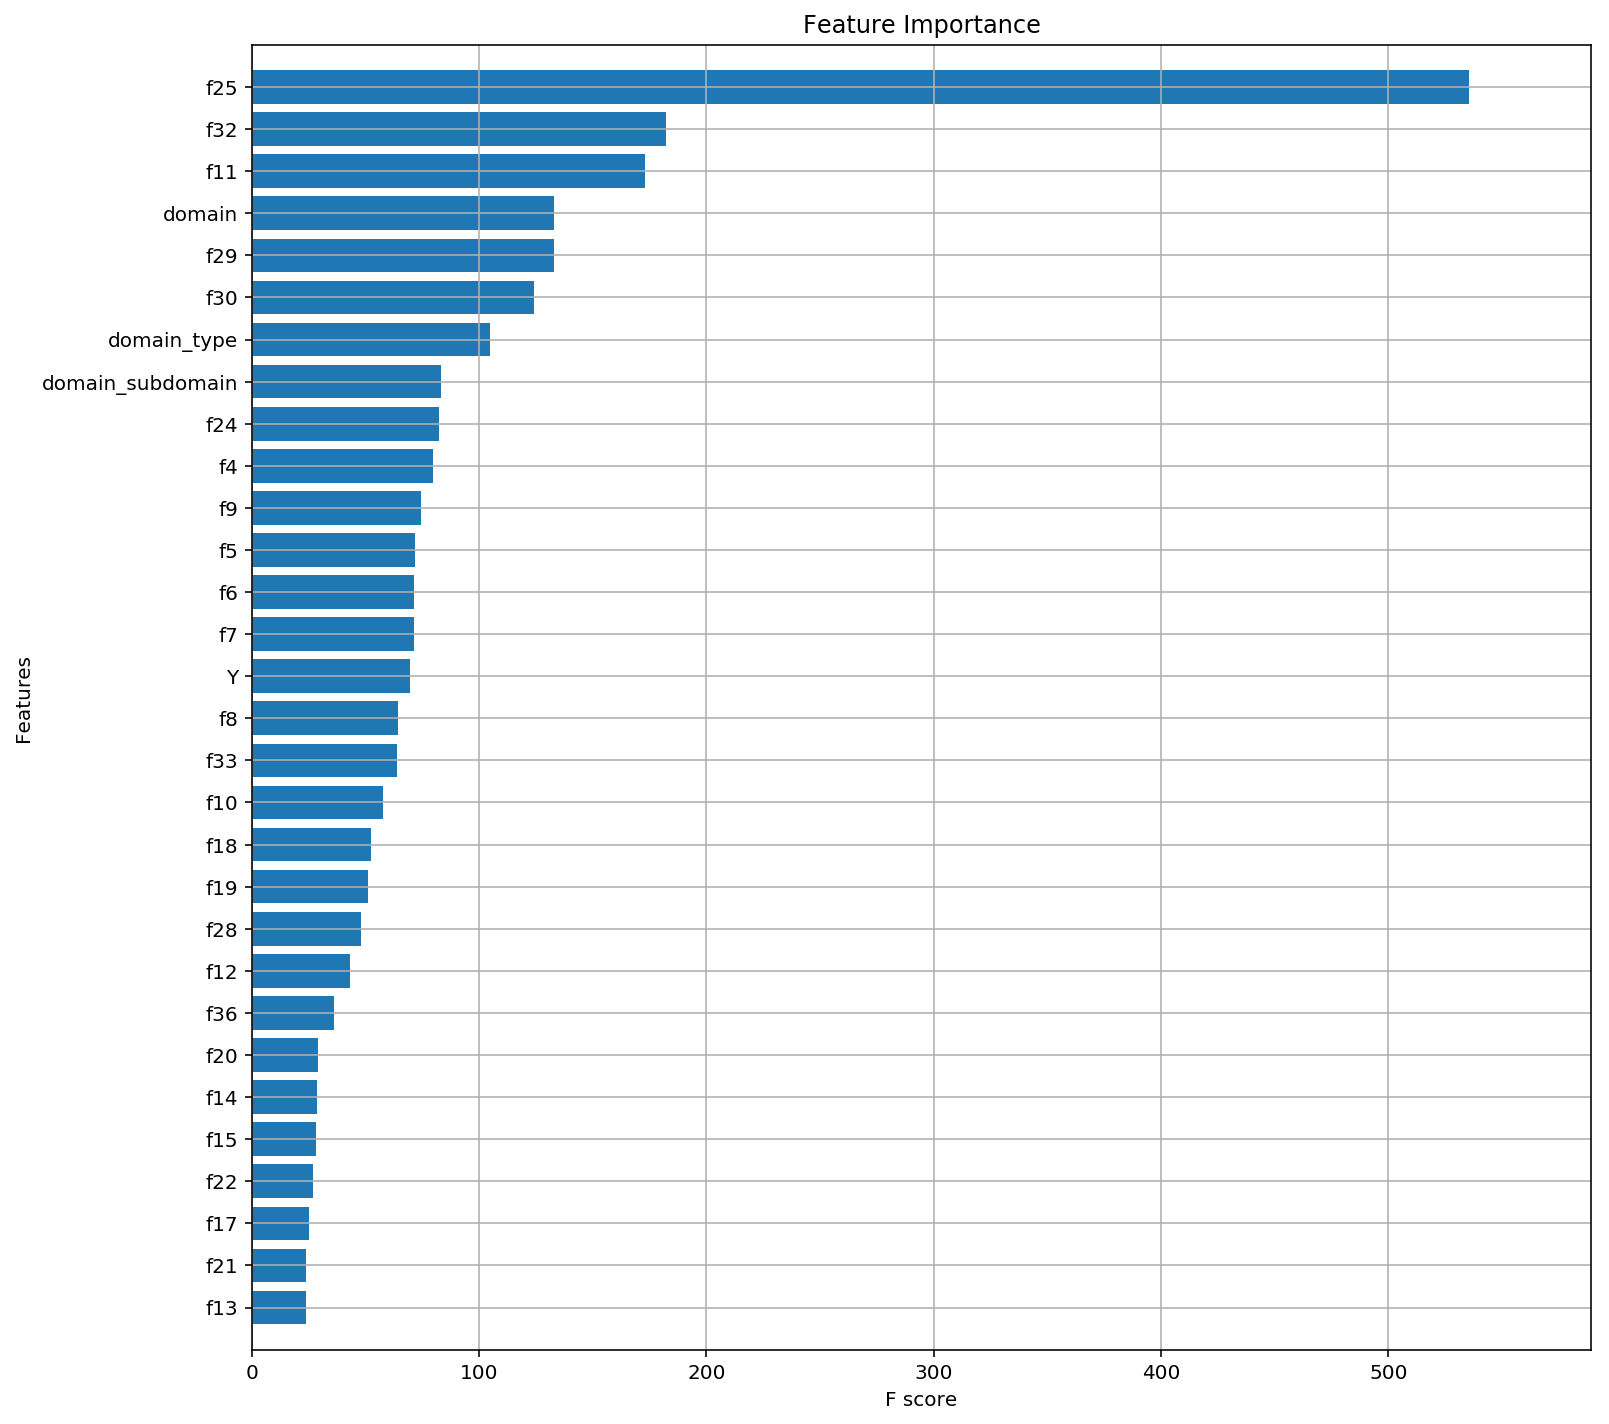

In [54]:
import xgboost
map_names = dict(zip(model.feature_names, df_domains.columns))
model.feature_names = list(map_names.values())

#plot feature importance
fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(model, importance_type='gain', max_num_features=30, height=0.8, ax=ax, show_values = False)
plt.title('Feature Importance')
plt.show()

#### Deploy the model

In [55]:
## Deploy trained XGBoost model endpoint to perform predictions
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.t2.medium')


-------------------!

In [66]:
# make sure to set content type to csv as we have data in csv format
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None


#### Test Model using test data from local file

In [95]:
## Function to chunk down test set into smaller increments

def predict(data, model, rows=500):
    split_array = np.array_split(data, int(len(data) / float(rows) + 1))
    predictions = ''
    for array in split_array:
        #print(array[0])
        predictions = ','.join([predictions, model.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [96]:


## Generate predictions on the test set for the difference models
with open('single.test', 'r') as f:
    payload = f.read().strip()
labels = [int(line[0]) for line in payload.split('\n')]
test_data = [line[2:] for line in payload.split('\n')]
predictions = predict(test_data, xgb_predictor)
#xgb_predictor.predict(payload[2:]).decode('utf-8')
predictions



9,20,4,1,9,12,25,4,15,3,21,13,5,14,20,1,20,9,15,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


array([0.15963431])

In [74]:
# take one records from test file
if 'win' in platform:
    !powershell -command "& {Get-Content domainsDataSet.test -TotalCount 10}" > ten_records.test
else:
    !head -10 domainsDataSet.test > ten_records.test

In [81]:

## Generate predictions on the test set for the difference models
with open('ten_records.test', 'r') as f:
    payload = f.read().strip()
labels = [int(line[0]) for line in payload.split('\n')]
test_data = [line[2:] for line in payload.split('\n')]
predictions = predict(test_data, xgb_predictor)
#xgb_predictor.predict(payload[2:]).decode('utf-8')
predictions

array([0.15963431, 0.9996438 , 0.27319884, 0.86056608, 0.99931133,
       0.99997187, 0.09099584, 0.01169408, 0.25270784, 0.99987197])

Test is all test data

In [82]:
## Generate predictions on the test set for the difference models
with open('domainsDataSet.test', 'r') as f:
    payload = f.read().strip()
labels = [int(line[0]) for line in payload.split('\n')]
test_data = [line[2:] for line in payload.split('\n')]
predictions = predict(test_data, xgb_predictor)
#xgb_predictor.predict(payload[2:]).decode('utf-8')
from sklearn.metrics import accuracy_score ,confusion_matrix
thresh = 0.5
y_pred = predictions
y_pred_binary = np.where(predictions > thresh, 1, 0)
accuracy_score(labels,y_pred_binary)
confusion_matrix(labels,y_pred_binary)

0.950925

array([[96637,  3117],
       [ 6698, 93548]], dtype=int64)

#### Create function to test using sagemaker runtime client

In [145]:
import os
import io
import boto3
import json
import tldextract

# grab environment variables
ENDPOINT_NAME = os.getenv('ENDPOINT_NAME','XGBoostEndpoint-2020-05-08-14-42-46')
runtime= boto_session.client('runtime.sagemaker')

def extract_domain(record):
    domain = record
    ret=''
    try:
        ext = tldextract.extract(domain)
        ret = ext.domain
    except :
        print(record)
    return ret

VALID_CHARS = 'abcdefghijklmnopqrstuvwxyz0123456789-_.'
LOOKUP_TABLE = None
def pad(l, content, width):
        l.extend([content] * (width - len(l)))
        return l

def features(domain): 
    
    global VALID_CHARS    
    global LOOKUP_TABLE    
    if not LOOKUP_TABLE:        
        LOOKUP_TABLE = dict()       
        idx = 1
        for c in VALID_CHARS:
            LOOKUP_TABLE[c] = int(idx)            
            idx += int(1)    
    rvalue = list()  
    if len(domain)<=63 and ' ' not in domain:
        for c in domain.lower():        
            rvalue.append(str(LOOKUP_TABLE[c]))
    else: 
        #print(domain)
        pass
            
    rvalue=pad(rvalue,'0',63)
    return ','.join(rvalue)
def lambda_handler(event, context):
    print("Received event: " + json.dumps(event, indent=2))
    
    data = json.loads(json.dumps(event))
    payload = data['fqdn']
    #print(payload)
    # extract domain 
    
    domain = extract_domain(payload)
    feature_X = features(domain)
    #print(feature_X)
    response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                       ContentType='text/csv',
                                       Body=feature_X)
    #print(response)
    pred = json.loads(response['Body'].read().decode())
    print(pred)
    predicted_label = 'dga' if pred > .5 else 'benign'
    
    return predicted_label

In [133]:
event= {'fqdn':'www.google.com'}
context=None
lambda_handler(event,context)

Received event: {
  "fqdn": "www.google.com"
}
0.01288378145545721


'benign'

In [136]:
df_feedback = pd.read_csv('feedback.csv')
df_feedback.head(5)
df_feedback.columns= ['domain','submitted','correct']

,domain,submitted,correct
0,uocoqgiusyeciouaimcauykqswsymo,benign,dga
1,409485,dga,benign
2,m8sdetc0u81lgdcpshoxsvy,benign,dga
3,cyneugril,benign,dga
4,eikmcosam,benign,dga


In [137]:
df_feedback.loc[:,'TesT'] = df_feedback.apply(lambda row: lambda_handler({'fqdn':row['domain']},None), axis=1)


Received event: {
  "fqdn": "uocoqgiusyeciouaimcauykqswsymo"
}
0.9900224804878235
Received event: {
  "fqdn": "409485"
}
0.13982851803302765
Received event: {
  "fqdn": "m8sdetc0u81lgdcpshoxsvy"
}
0.9678484797477722
Received event: {
  "fqdn": "cyneugril"
}
0.3343791961669922
Received event: {
  "fqdn": "eikmcosam"
}
0.10682667046785355
Received event: {
  "fqdn": "mamysymikazadoci"
}
0.31449007987976074
Received event: {
  "fqdn": "phunuthudo"
}
0.5692185759544373
Received event: {
  "fqdn": "egrsdno"
}
0.39366620779037476
Received event: {
  "fqdn": "nfwkowelcamino"
}
0.44702982902526855
Received event: {
  "fqdn": "npowancorml"
}
0.04577593877911568
Received event: {
  "fqdn": "293054"
}
0.009585773572325706
Received event: {
  "fqdn": "skeyggikcecycsgcqwksigkswo"
}
0.988801121711731
Received event: {
  "fqdn": "nwdzmqgfajecupinz"
}
0.9995905756950378
Received event: {
  "fqdn": "fogykuhovaxavaniholijiq"
}
0.8631207942962646
Received event: {
  "fqdn": "ynwambrkriny"
}
0.89282977581

In [138]:
from sklearn.metrics import accuracy_score ,confusion_matrix
df_feedback.columns
labels = df_feedback.correct
preds = df_feedback.TesT
accuracy_score(labels,preds)
confusion_matrix(labels,preds)

Index(['domain', 'submitted', 'correct', 'TesT'], dtype='object')

0.6261682242990654

array([[27,  4],
       [36, 40]], dtype=int64)

In [36]:
# we use the Hyperparameter Tuner
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import HyperparameterTuner

# Define exploration boundaries (default suggested values from Amazon SageMaker Documentation)
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 1000, scaling_type="Auto"),
    'colsample_bylevel': ContinuousParameter(0.1, 1,scaling_type="Logarithmic"),
    'colsample_bytree': ContinuousParameter(0.5, 1, scaling_type='Logarithmic'),
    'eta': ContinuousParameter(0.1, 0.5, scaling_type='Logarithmic'),
    'gamma':ContinuousParameter(0, 5, scaling_type='Auto'),
    'lambda': ContinuousParameter(0,100,scaling_type='Auto'),
    'max_delta_step': IntegerParameter(0,10,scaling_type='Auto'),
    'max_depth': IntegerParameter(0,10,scaling_type='Auto'),
    'min_child_weight': ContinuousParameter(0,10,scaling_type='Auto'),
    'num_round': IntegerParameter(1,4000,scaling_type='Auto'),
    'subsample': ContinuousParameter(0.5,1,scaling_type='Logarithmic')}

objective_metric_name = 'validation:accuracy'

tuner_log = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=60,
    max_parallel_jobs=3,
    strategy='Bayesian'
)

## Starts the hyperparameter tuning job
tuner_log.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

## Prints the status of the latest hyperparameter tuning job
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'InProgress'

In [ ]:
status = sagemaker_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']
print(status)
while status !='Completed' and status!='Failed':
    time.sleep(600)
    status =  sagemaker_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']
    print(status)

In [ ]:
# get the best performance model job name from console and create endpoint and then predict using test data

In [140]:
%%time
# Import model for hosting

from time import gmtime, strftime
job_name='sagemaker-xgboost-200508-0001-004-0bb812be'
model_name=job_name + '-model'
print(model_name)

info = sagemaker_client.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = sagemaker_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

sagemaker-xgboost-200508-0001-004-0bb812be-model
s3://sagemaker-us-west-2-099176660580/sagemaker/xgboost/output/sagemaker-xgboost-200508-0001-004-0bb812be/output/model.tar.gz
arn:aws:sagemaker:us-west-2:099176660580:model/sagemaker-xgboost-200508-0001-004-0bb812be-model
Wall time: 603 ms


In [141]:
# create endpoint configuration
from time import gmtime, strftime

endpoint_config_name = 'XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':"ml.m5.large",
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

XGBoostEndpointConfig-2020-05-08-14-42-36
Endpoint Config Arn: arn:aws:sagemaker:us-west-2:099176660580:endpoint-config/xgboostendpointconfig-2020-05-08-14-42-36


In [142]:
%%time
# create end point

import time

endpoint_name = 'XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sagemaker_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
while status=='Creating':
    print("Status: " + status)
    time.sleep(60)
    resp = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

XGBoostEndpoint-2020-05-08-14-42-46
arn:aws:sagemaker:us-west-2:099176660580:endpoint/xgboostendpoint-2020-05-08-14-42-46
Status: Creating


NameError: name 'client' is not defined

In [144]:
status = resp['EndpointStatus']
while status=='Creating':
    print("Status: " + status)
    time.sleep(60)
    resp = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Arn: arn:aws:sagemaker:us-west-2:099176660580:endpoint/xgboostendpoint-2020-05-08-14-42-46
Status: InService


In [146]:
# load test data from assignment and write function to test one record at a time
df_feedback = pd.read_csv('feedback.csv')
df_feedback.head(5)
df_feedback.columns= ['domain','submitted','correct']
df_feedback.loc[:,'TesT'] = df_feedback.apply(lambda row: lambda_handler({'fqdn':row['domain']},None), axis=1)

,domain,submitted,correct
0,uocoqgiusyeciouaimcauykqswsymo,benign,dga
1,409485,dga,benign
2,m8sdetc0u81lgdcpshoxsvy,benign,dga
3,cyneugril,benign,dga
4,eikmcosam,benign,dga


Received event: {
  "fqdn": "uocoqgiusyeciouaimcauykqswsymo"
}
0.9681313037872314
Received event: {
  "fqdn": "409485"
}
0.4691585898399353
Received event: {
  "fqdn": "m8sdetc0u81lgdcpshoxsvy"
}
0.6902233958244324
Received event: {
  "fqdn": "cyneugril"
}
0.38289549946784973
Received event: {
  "fqdn": "eikmcosam"
}
0.10572189837694168
Received event: {
  "fqdn": "mamysymikazadoci"
}
0.40307381749153137
Received event: {
  "fqdn": "phunuthudo"
}
0.779487669467926
Received event: {
  "fqdn": "egrsdno"
}
0.2310580611228943
Received event: {
  "fqdn": "nfwkowelcamino"
}
0.6114158034324646
Received event: {
  "fqdn": "npowancorml"
}
0.30408012866973877
Received event: {
  "fqdn": "293054"
}
0.30871859192848206
Received event: {
  "fqdn": "skeyggikcecycsgcqwksigkswo"
}
0.9046083688735962
Received event: {
  "fqdn": "nwdzmqgfajecupinz"
}
0.992576003074646
Received event: {
  "fqdn": "fogykuhovaxavaniholijiq"
}
0.6297433972358704
Received event: {
  "fqdn": "ynwambrkriny"
}
0.804383873939514

In [147]:
from sklearn.metrics import accuracy_score ,confusion_matrix
df_feedback.columns
labels = df_feedback.correct
preds = df_feedback.TesT
accuracy_score(labels,preds)
confusion_matrix(labels,preds)

Index(['domain', 'submitted', 'correct', 'TesT'], dtype='object')

0.6074766355140186

array([[26,  5],
       [37, 39]], dtype=int64)

In [148]:
df_feedback[df_feedback.correct!=df_feedback.TesT]

,domain,submitted,correct,TesT
3,cyneugril,benign,dga,benign
4,eikmcosam,benign,dga,benign
5,mamysymikazadoci,benign,dga,benign
6,phunuthudo,dga,benign,dga
9,npowancorml,benign,dga,benign
16,kepyponepadolecepikubyz,benign,dga,benign
17,galosibapedos,benign,dga,benign
24,eezcareisbad,benign,dga,benign
26,ppvvebrags,benign,dga,benign
31,wolf60ffm,dga,benign,dga


In [151]:
# Dont forgot to delete end point
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '2eb7702e-0aa1-453c-9969-b73472c05306',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2eb7702e-0aa1-453c-9969-b73472c05306',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 08 May 2020 15:38:25 GMT'},
  'RetryAttempts': 0}}

In [153]:
sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

{'ResponseMetadata': {'RequestId': '8e9192f7-c8c9-4c6c-98d0-5e8ed0b22bfe',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8e9192f7-c8c9-4c6c-98d0-5e8ed0b22bfe',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 08 May 2020 15:39:26 GMT'},
  'RetryAttempts': 0}}